<a href="https://colab.research.google.com/github/PHastings37/Mphys-proj/blob/main/loading%20and%20masking%20images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import tciaclient as tcia
import SimpleITK as sitk
import pydicom
import os
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
from rt_utils import RTStructBuilder

In [ ]:
import zipfile
path = os.listdir('zipped files')
counter = 0
for i in path:
  counter += 1
  with zipfile.ZipFile('zipped files/{}'.format(i), 'r') as zip_ref:
    folder = "patient{}".format(counter)
    os.mkdir(folder)
    zip_ref.extractall(folder)


In [11]:
"""
code to traverse given patients file and create an array of a given data entry.

"""
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
import os, os.path
import SimpleITK as sitk
from __future__ import print_function
import sys
import os
reader = sitk.ImageSeriesReader()
import numpy as np

filepath = "/mnt/c/Users/Patrick/Documents/MPHYS_DATA_SORTED"
counter = 0 #Used to check that the code is running

#Defining the start of the path name to where my files are (this depends on your path and the
# naming scheme you used when using dicomsort.py)
directory = '/mnt/c/Users/Patrick/Documents/MPHYS_DATA_SORTED/LUNG1-'

# defining the start of the path name of the output file

output_file = '/mnt/c/Users/Patrick/Documents/MPHYS_DATA_SORTED/LUNG1-'


#defining the number of iterations the for loop will perform. +1 is due to the range function
number_of_iterations = 422+1

biggest_size = 0
biggest_size_label = 0
size =[]
spacing = []

for x in range(1, number_of_iterations) :
    _3_digit_x = '{0:03}'.format(x) #formats the 'x' to the form 'yzx' e.g. 1 -> 001
                                    # so that it fits the format of the naming scheme used
                                    # e.g. LUNG1-001-CT
    
    directory_full = directory + str(_3_digit_x) + '-CT/' #   This line will change depending on the naming scheme that you have used
    dicom_names = reader.GetGDCMSeriesFileNames(directory_full)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    size.append((image.GetSize()))
    spacing.append((image.GetSpacing()))
    print(x)

size = np.vstack(size)
spacing = np.vstack(spacing)

KeyboardInterrupt: 

In [162]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#checks if image size or shape needs to be changed
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if np.max(size[:,0]) == np.min(size[:,0]) and np.max(size[:,1]) == np.min(size[:,1]):
    print("no resizing necessary")
else:
    print(f"resizing necessary, resize to {np.max(size[:,0])}x{np.max[size[:,1]]}")
    
"""
mode_x = stats.mode(spacing[:,0])
mode_y = stats.mode(spacing[:,1])
mode_z = stats.mode(spacing[:,2])
"""
#resize data from prev run
mode_x, mode_y = 0.9765625
mode_z = 3
if np.max(spacing[:,0]) == np.min(spacing[:,0]) and np.max(spacing[:,1]) == np.min(spacing[:,1]):
    print("no respacing necessary")
else:
    print(f"respacing necessary, resize to {mode_x.mode}x{mode_y.mode}x{mode_z.mode}")

no resizing necessary
respacing necessary, resize to [0.9765625]x[0.9765625]x[5.]


In [87]:
###
#Code resamples and resizes data before writing all the data to nifty files, which are VERY LARGE
###
from scipy import stats

def WL_norm(img, window=1500, level=-400):
    """
    supposed levels for lungs are 1500 and -400
    Apply window and level to image
    """
    
    maxval = level + window/2
    minval = level - window/2
    wl = sitk.IntensityWindowingImageFilter()
    wl.SetWindowMaximum(maxval)
    wl.SetWindowMinimum(minval)
    out = wl.Execute(img)
    return out
 

def resample_volume(volume, interpolator = sitk.sitkLinear, new_spacing = [mode_x, mode_y, mode_z]):

    new_size = [512, 512, 512]
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(interpolator)
    resample.SetOutputDirection(volume.GetDirection())
    resample.SetOutputOrigin(volume.GetOrigin())
    resample.SetSize(new_size)
    resample.SetOutputSpacing([1, 1, 3])
    resample.SetDefaultPixelValue(-1024)
    #resample.SetSizeOfPixelComponent(2)

    return resample.Execute(volume)

counter = 0
for filename in os.listdir(filepath):
    if "-CT" in filename:
        print(filename)
        reader = sitk.ImageSeriesReader()
        dcm_paths =reader.GetGDCMSeriesFileNames(os.path.join(filepath,filename))  

        reader.SetFileNames(dcm_paths)
        volume = sitk.ReadImage(dcm_paths)
    
        x = resample_volume(volume)
        rtstruct = RTStructBuilder.create_from(
            dicom_series_path=f"{filepath}/LUNG1-001-CT", 
            rt_struct_path=f"{filepath}/LUNG1-001-RTSTRUCT/3-2.dcm")
        maskimge = sitk.Mask(x, rtstruct.get_roi_mask_by_name("Lung-Right"), outsideValue = 0, maskingValue = 0)

        counter += 1
        sitk.WriteImage(x, "/mnt/c/Users/Patrick/Documents/MPHYS_DATA_NIFTY/test1.nii")

        break
        

    else:
        continue

# rtstruct = RTStructBuilder.create_from(
#         dicom_series_path=f"{filepath}/LUNG1-001-CT", 
#         rt_struct_path=f"{filepath}/LUNG1-001-RTSTRUCT/3-2.dcm"
#     )

# print(rtstruct.get_roi_names())

# mask_3d = rtstruct.get_roi_mask_by_name("Lung-Right")
# first_mask_slice = mask_3d[:, :, 50]

# plt.imshow(first_mask_slice)
# plt.show()
    


LUNG1-001-CT


TypeError: in method 'Mask', argument 2 of type 'itk::simple::Image const &'

In [ ]:
#masking trial
import SimpleITK as sitk
reader = sitk.ImageSeriesReader()
dcm_path = reader.GetGDCMSeriesFileNames(f"{filepath}/LUNG1-001-CT")
reader.SetFileNames(dcm_path)
 
image = sitk.ReadImage(f'{dcm_path}/0-1')
foreground_mask = image>0
foreground_image = image.sitk.Cast(foreground_mask, image.GetPixelID())
sitk.WriteImage(foreground_image, "/mnt/c/Users/Patrick/Documents/MPHYS_DATA_NIFTY/masktest.nii")

(512, 512)
(450, 450)


<function matplotlib.pyplot.show>

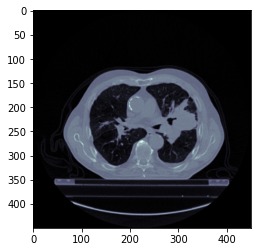

In [124]:
ds = dcmread('patient1/86-b5e50e558c7d692111ee5cc5b4b3123b.dcm')
data = ds.pixel_array
print(data.shape)

from skimage.transform import resize
imgpxsize = 450
resizedimg = resize(data, (imgpxsize, imgpxsize), anti_aliasing=True)
print(resizedimg.shape)

plt.imshow(resizedimg, cmap=plt.cm.bone)
plt.show

<function matplotlib.pyplot.show>

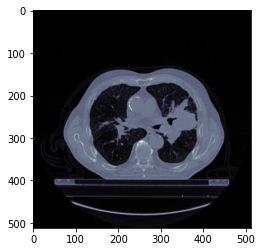

In [118]:
ds = dcmread('patient1/86-b5e50e558c7d692111ee5cc5b4b3123b.dcm')
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.show